#Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19

## Подготовка среды


In [197]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

!pip install pyspark -q

In [198]:
!java -version
!python --version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)
Python 3.12.12


In [199]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("COVID-19 X-Ray Analysis") \
    .master("local[*]") \
    .getOrCreate()

print(f"Spark версия: {spark.version}")

Spark версия: 4.0.1


In [200]:
# библиотеки PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# для работы с данными
import pandas as pd
import numpy as np
# для парсинга дат
!pip install python-dateutil -q
from dateutil import parser
from datetime import datetime

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

In [201]:
# Скачиваем metadata.csv из репозитория
!wget -q https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv

# Загружаем в Spark DataFrame
df = spark.read.csv("metadata.csv", header=True, inferSchema=True)

print(f"Записей: {df.count()}")
print(f"Колонок: {len(df.columns)}")

Записей: 950
Колонок: 30


Проверка операция с данными

In [202]:
df.show(5)

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|_c29|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+---------------

In [203]:
df.printSchema()        # схема (типы колонок)

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

#Предобработка и анализ качества данных
##Распределение пропущенных значений


 Поля с наибольшим процентом пропусков:
                        null_count  missing_percent
_c29                         935.0        98.421053
leukocyte_count              934.0        98.315789
neutrophil_count             922.0        97.052632
extubated                    913.0        96.105263
lymphocyte_count             910.0        95.789474
temperature                  872.0        91.789474
needed_supplemental_O2       860.0        90.526316
pO2_saturation               831.0        87.473684
intubated                    702.0        73.894737
intubation_present           700.0        73.684211
in_icu                       615.0        64.736842
survival                     589.0        62.000000
doi                          568.0        59.789474
went_icu                     553.0        58.210526
other_notes                  510.0        53.684211


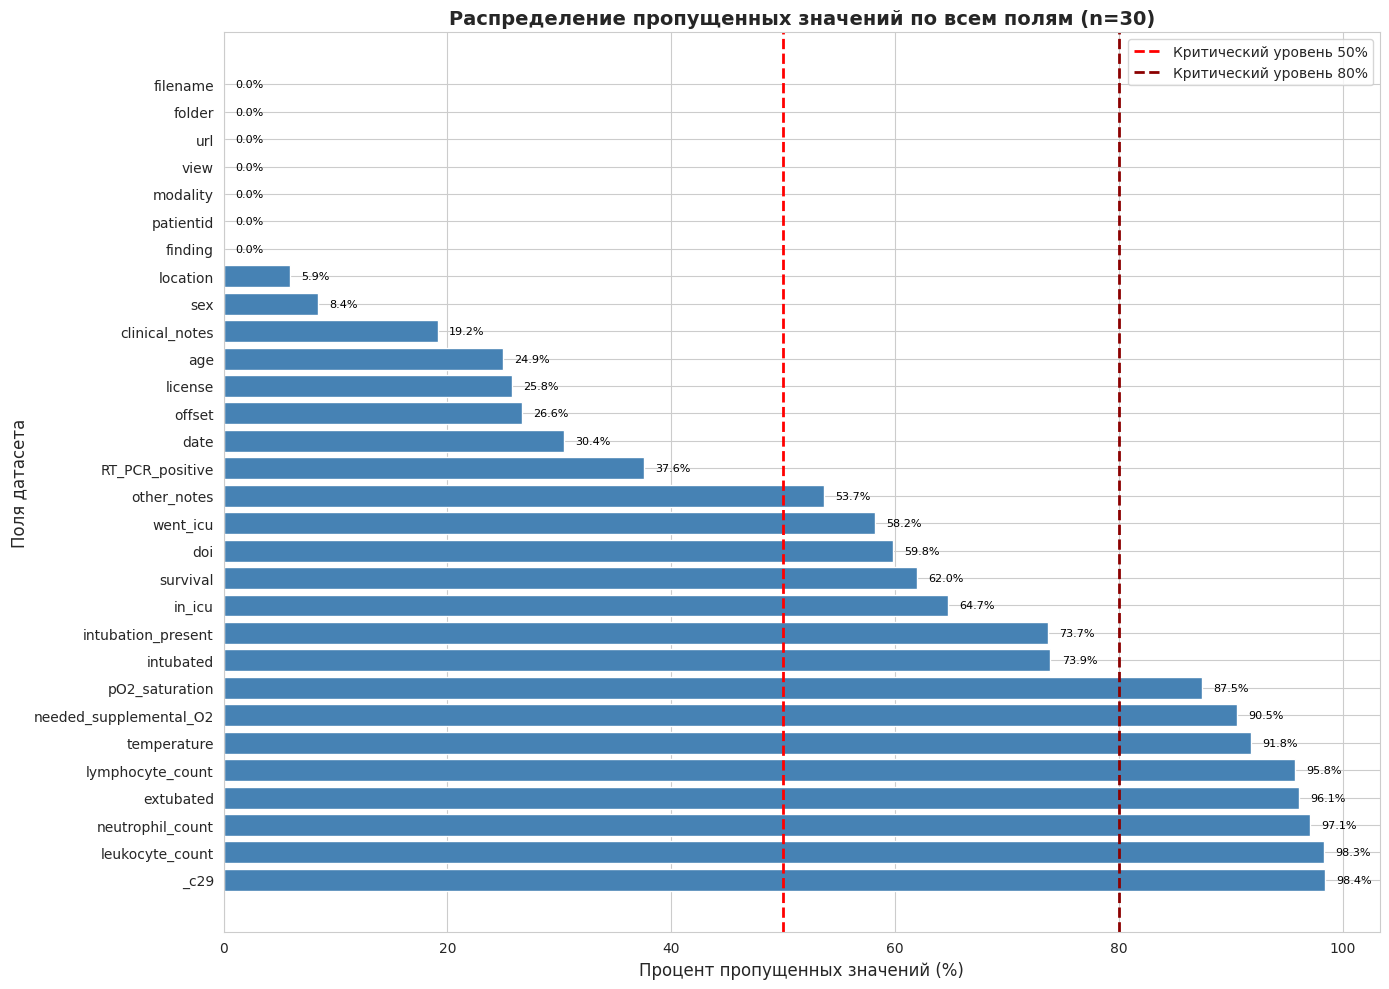


 Статистика по уровням пропусков:
  • Поля с >80% пропусков: 8 шт.
  • Поля с 50-80% пропусков: 7 шт.
  • Поля с <50% пропусков: 15 шт.


In [204]:
total_records = df.count()

# Рассчитываем пропуски для всех полей
missing_dict = {}
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    missing_pct = (null_count / total_records) * 100
    missing_dict[col_name] = {
        'null_count': null_count,
        'missing_percent': missing_pct
    }

# Преобразуем в pandas для удобства
missing_df = pd.DataFrame(missing_dict).T
missing_df = missing_df.sort_values('missing_percent', ascending=False)

print("\n Поля с наибольшим процентом пропусков:")
print(missing_df.head(15).to_string())

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 10))
bars = plt.barh(missing_df.index, missing_df['missing_percent'], color='steelblue')

for idx, (bar, pct) in enumerate(zip(bars, missing_df['missing_percent'])):
    plt.text(pct + 1, idx, f'{pct:.1f}%',
             va='center', fontsize=8, color='black')

plt.xlabel('Процент пропущенных значений (%)', fontsize=12)
plt.ylabel('Поля датасета', fontsize=12)
plt.title(f'Распределение пропущенных значений по всем полям (n={len(df.columns)})',
          fontsize=14, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2,
            label='Критический уровень 50%')
plt.axvline(x=80, color='darkred', linestyle='--', linewidth=2,
            label='Критический уровень 80%')
plt.legend()
plt.tight_layout()
plt.show()

# Статистика по уровням пропусков
fields_over_80 = missing_df[missing_df['missing_percent'] > 80]
fields_50_80 = missing_df[(missing_df['missing_percent'] > 50) &
                          (missing_df['missing_percent'] <= 80)]
fields_under_50 = missing_df[missing_df['missing_percent'] <= 50]

print(f"\n Статистика по уровням пропусков:")
print(f"  • Поля с >80% пропусков: {len(fields_over_80)} шт.")
print(f"  • Поля с 50-80% пропусков: {len(fields_50_80)} шт.")
print(f"  • Поля с <50% пропусков: {len(fields_under_50)} шт.")

##Выявление аномальных значений

### Анализ числовых полей - 'age'

  Логические аномалии: 0
  Статистические выбросы: 0


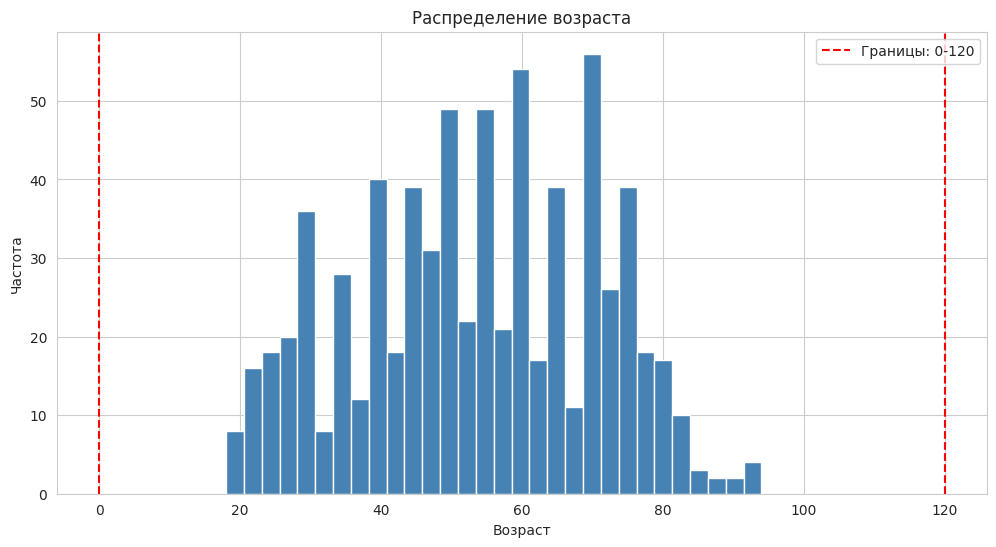

In [205]:
# Логические аномалии
age_negative = df.filter(col('age') < 0).count()
age_over_120 = df.filter(col('age') > 120).count()
print(f"  Логические аномалии: {age_negative + age_over_120}")

# Статистические выбросы
quantiles = df.approxQuantile('age', [0.25, 0.75], 0.01)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df.filter((col('age') < lower) | (col('age') > upper)).count()
print(f"  Статистические выбросы: {outliers}")

# ОДИН простой график
age_data = df.select('age').toPandas()
plt.hist(age_data['age'].dropna(), bins=30, color='steelblue')
plt.axvline(0, color='red', linestyle='--', label='Границы: 0-120')
plt.axvline(120, color='red', linestyle='--')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста')
plt.legend()
plt.show()

### Приведение к единому формату и анализ поля 'date'


  СТАТИСТИКА:
    Всего: 950
    NULL: 289
    Распарсено: 661
    Не распарсено: 0

  АНОМАЛИИ:
    Будущее: 0
    До COVID: 104

  Распределение:
    year  count
0   2003      5
1   2004     11
2   2007      1
3   2009      3
4   2010      6
5   2011      5
6   2013      7
7   2014     11
8   2015     25
9   2016     20
10  2017      4
11  2018      6
12  2019     10
13  2020    547


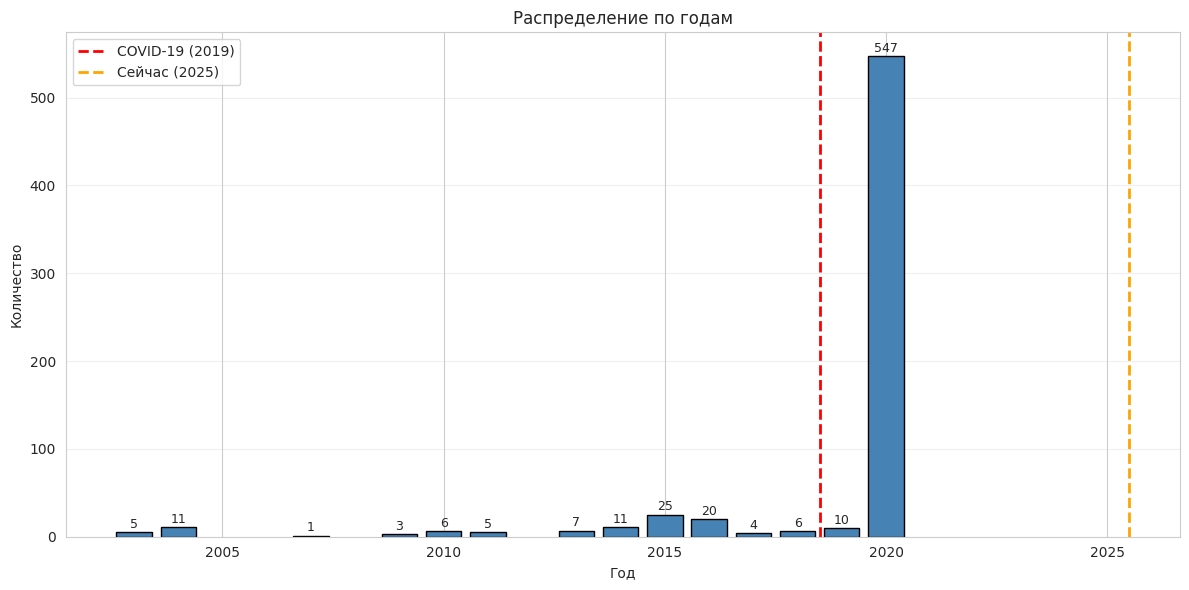

In [206]:
# Фиксированный список форматов (из примера проекта)
formats = [
    "%Y-%m-%d",     # для уже распарсенных дат
    "%B %d, %Y", "%b %d, %Y", "%d %B %Y", "%d %b %Y",
    "%m/%d/%Y", "%m/%d/%y", "%B %Y", "%b %Y",
    "%Y", "%B %d", "%b %d"
]

# Функция парсинга
def parse_date(date_str):
    if not date_str:
        return None
    for fmt in formats:
        try:
            result = datetime.strptime(str(date_str).strip(), fmt).date()
            if fmt in ["%B %d", "%b %d"]:
                result = result.replace(year=2020)
            return result
        except:
            continue
    return None

# Применяем UDF
parse_date_udf = udf(parse_date, DateType())
df = df.withColumn('date_new', parse_date_udf(col('date')))

# Статистика
total = df.count()
null_before = df.filter(col('date').isNull()).count()
parsed = df.filter(col('date_new').isNotNull()).count()
failed = df.filter(col('date').isNotNull() & col('date_new').isNull()).count()

print(f"\n  СТАТИСТИКА:")
print(f"    Всего: {total}")
print(f"    NULL: {null_before}")
print(f"    Распарсено: {parsed}")
print(f"    Не распарсено: {failed}")

# Показываем нераспарсенные
if failed > 0:
    print(f"\n  Нераспарсенные даты:")
    df.filter(col('date').isNotNull() & col('date_new').isNull()) \
      .select('date').distinct().show(10, truncate=False)

# Заменяем колонку
df = df.drop('date').withColumnRenamed('date_new', 'date')

# Аномалии
current_year = datetime.now().year
date_future = df.filter(year(col('date')) > current_year).count()
date_before_covid = df.filter(year(col('date')) < 2019).count()

print(f"\n  АНОМАЛИИ:")
print(f"    Будущее: {date_future}")
print(f"    До COVID: {date_before_covid}")

# График
year_dist = df.filter(col('date').isNotNull()) \
              .groupBy(year(col('date')).alias('year')).count() \
              .orderBy('year').toPandas()

if len(year_dist) > 0:
    year_dist['year'] = year_dist['year'].astype(int)
    print(f"\n  Распределение:\n{year_dist}")

    plt.figure(figsize=(12, 6))
    plt.bar(year_dist['year'], year_dist['count'], color='steelblue', edgecolor='black')
    plt.axvline(2018.5, color='red', linestyle='--', linewidth=2, label='COVID-19 (2019)')
    plt.axvline(current_year + 0.5, color='orange', linestyle='--', linewidth=2, label=f'Сейчас ({current_year})')

    for _, row in year_dist.iterrows():
        plt.text(row['year'], row['count'] + 5, str(row['count']), ha='center', fontsize=9)

    plt.xlabel('Год')
    plt.ylabel('Количество')
    plt.title('Распределение по годам')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n   Нет данных для графика!")

###Проверка категориальных полей

In [207]:
print("\n Анализ категориальных полей:")

for field in ['sex', 'finding', 'view']:
    if field in df.columns:
        unique_count = df.select(field).distinct().count()
        print(f"\n  • {field}: {unique_count} уникальных значений")

        # Показываем распределение
        print(f"    Распределение (топ-10):")
        df.groupBy(field).count() \
          .orderBy(col('count').desc()) \
          .show(10, truncate=False)

        # Выявляем подозрительные значения (например, '???', 'unknown', числа вместо категорий)
        suspicious = df.filter(
            col(field).rlike(r'^\?+$|^unknown$|^\d+$')
        ).count()

        if suspicious > 0:
            print(f"     Подозрительных значений: {suspicious}")


 Анализ категориальных полей:

  • sex: 3 уникальных значений
    Распределение (топ-10):
+----+-----+
|sex |count|
+----+-----+
|M   |559  |
|F   |311  |
|NULL|80   |
+----+-----+


  • finding: 25 уникальных значений
    Распределение (топ-10):
+---------------------------------+-----+
|finding                          |count|
+---------------------------------+-----+
|Pneumonia/Viral/COVID-19         |584  |
|todo                             |83   |
|Pneumonia                        |81   |
|Pneumonia/Fungal/Pneumocystis    |30   |
|No Finding                       |22   |
|Pneumonia/Bacterial/Streptococcus|22   |
|Tuberculosis                     |18   |
|Pneumonia/Viral/SARS             |16   |
|Pneumonia/Lipoid                 |13   |
|Pneumonia/Bacterial/Mycoplasma   |11   |
+---------------------------------+-----+
only showing top 10 rows

  • view: 7 уникальных значений
    Распределение (топ-10):
+---------+-----+
|view     |count|
+---------+-----+
|PA       |344  |
|AP Su

При анализе данных выявлены критические проблемы датасета:

8 полей имеют >80% пропущенных значений

_c29, leukocyte_count, neutrophil_count,     extubated, lymphocyte_count, temperature,
needed_supplemental_O2, pO2_saturation

7 полей с 50-80% пропусков

(intubated, intubation_present, in_icu, survival, doi, went_icu, other_notes)

В таком виде эти данные непригодны для статистического анализа. Заполнение пропусков приведет к искажению данныхъ и нерелевантности резульотатов анализа (анализ будет проведен преимущественно на сгенерированных, синтетических данных)

Обоснование отбора полей:

1. patientId (0.0% пропусков)
   Это уникальный идентификатор пациента

2. finding (0.0% пропусков) это ключевое поле -  Диагноз. Основа для классификации пациентов, но требует унификации (множественные варианты написания)

3. view (0.0% пропусков) - Проекция снимка (PA, AP, L)

4. sex (8.4% пропусков) - Демографическая характеристика, важно для гендерного анализа заболеваемости и выявления групп риска по полу. % пропусков низкий

5. age (26.9% пропусков) - Демографическая характеристика, так же важно для анализа возрастных групп риска и выявления уязвимых категорий населения. Возраст часто коррелируется с течение, тяжестью и подверженностью заболеваниея. Уровень 26,9% приемлем для заполнения медианой

6. date (41.1% пропусков) - временная метка. Важно для анализа динамики эпидемии, выявления временных трендов заболеваемости, пиков и спадов. Умеренный уровень пропусков, можно заполнить наиболее частым значением

Итого, отобранные поля представляют баланс между полнотой данных и ценностью с точки зрения анализа.

### Загрузка датасета с отобранными полями

In [208]:
df = df.select('patientid', 'age', 'sex', 'finding', 'view', 'date')

print(f"Исходных записей: {df.count()}")
print(f"Полей в датасете: {len(df.columns)}")
df.printSchema()

Исходных записей: 950
Полей в датасете: 6
root
 |-- patientid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: date (nullable = true)



###Удаление дубликатов

In [209]:
initial_count = df.count()
df = df.dropDuplicates()
duplicates_removed = initial_count - df.count()
print(f"\n[2] Удалено дубликатов: {duplicates_removed}")
print(f"    Осталось записей: {df.count()}")


[2] Удалено дубликатов: 282
    Осталось записей: 668


###Унификация диагнозов

In [210]:
#Унифицируем диагнозы по приоритетной схеме.
def unify_finding(finding):
    if finding is None:
        return 'Unknown'
    f = str(finding).lower().strip()
    if not f:
        return 'Unknown'
    if 'covid' in f or 'corona' in f:
        return 'COVID-19'
    if 'pneumonia' in f:
        return 'Pneumonia'
    if 'tuberculosis' in f or f == 'tb':
        return 'Tuberculosis'
    if 'normal' in f or 'no finding' in f:
        return 'Normal'
    return 'Other'

unify_finding_udf = udf(unify_finding, StringType())
df = df.withColumn('finding', unify_finding_udf(col('finding')))

print("    Распределение после унификации:")
df.groupBy('finding').count().orderBy(desc('count')).show()

    Распределение после унификации:
+------------+-----+
|     finding|count|
+------------+-----+
|    COVID-19|  437|
|   Pneumonia|  166|
|       Other|   28|
|      Normal|   20|
|Tuberculosis|   17|
+------------+-----+



###Заполнение пропусков вданных.

In [211]:
# Age - медиана
median_age = df.filter(col('age').isNotNull()).agg(F.expr('percentile_approx(age, 0.5)')).first()[0]
print(f"    • Age: медиана = {median_age:.1f}")
df = df.withColumn('age', when(col('age').isNull(), median_age).otherwise(col('age')))

# Sex - мода
sex_mode = df.filter(col('sex').isNotNull()).groupBy('sex').count().orderBy(desc('count')).first()[0]
print(f"    • Sex: мода = {sex_mode}")
df = df.withColumn('sex', when(col('sex').isNull(), sex_mode).otherwise(col('sex')))

# View - мода
view_mode = df.filter(col('view').isNotNull()).groupBy('view').count().orderBy(desc('count')).first()[0]
print(f"    • View: мода = {view_mode}")
df = df.withColumn('view', when(col('view').isNull(), view_mode).otherwise(col('view')))

# Date - удаляем записи без даты
date_nulls = df.filter(col('date').isNull()).count()
print(f"    • Date: удалено записей без даты = {date_nulls}")
df = df.filter(col('date').isNotNull())

    • Age: медиана = 54.0
    • Sex: мода = M
    • View: мода = PA
    • Date: удалено записей без даты = 204


Записи без даты были удалены из датасета.

Дата является критичным полем для эпидемиологического мониторинга и заполнение дат средними, частотными значениями или экстраполяция исказило бы временную динамику распространения COVID-19

In [212]:
# Финальная проверка - дубликаты
before_final = df.count()
df_final = df.dropDuplicates()
final_duplicates = before_final - df_final.count()
print(f"\n Финальная проверка дубликатов: {final_duplicates}")

#  на пропуски
print(f"\n Проверка финальных данных:")
for col_name in df_final.columns:
    null_count = df_final.filter(col(col_name).isNull()).count()
    print(f"    • {col_name}: {null_count} пропусков")

print(f"Финальных записей: {df_final.count()}")
print(f" Полей: {len(df_final.columns)}")

print("Примеры финальных данных:")
df_final.show(10, truncate=False)


 Финальная проверка дубликатов: 0

 Проверка финальных данных:
    • patientid: 0 пропусков
    • age: 0 пропусков
    • sex: 0 пропусков
    • finding: 0 пропусков
    • view: 0 пропусков
    • date: 0 пропусков
Финальных записей: 464
 Полей: 6
Примеры финальных данных:
+---------+---+---+---------+---------+----------+
|patientid|age|sex|finding  |view     |date      |
+---------+---+---+---------+---------+----------+
|57       |67 |F  |COVID-19 |PA       |2020-01-22|
|63       |54 |M  |COVID-19 |Axial    |2020-01-01|
|144      |30 |F  |COVID-19 |AP Supine|2020-01-01|
|340      |80 |M  |Pneumonia|PA       |2013-01-01|
|61       |38 |M  |COVID-19 |PA       |2020-01-01|
|224      |54 |F  |COVID-19 |AP Supine|2020-01-01|
|303      |74 |M  |COVID-19 |PA       |2020-01-01|
|345      |78 |F  |COVID-19 |PA       |2020-01-01|
|44       |78 |F  |COVID-19 |AP Supine|2020-01-01|
|49       |64 |M  |COVID-19 |PA       |2020-01-01|
+---------+---+---+---------+---------+----------+
only showing 

#SQL-аналитика


In [213]:
df_final.createOrReplaceTempView('covid_data')

##Запрос 1. Базовая статистика по диагнозам.

In [214]:
spark.sql("""
    SELECT
        finding,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS percentage,
        ROUND(AVG(age), 1) AS avg_age,
        MIN(age) AS min_age,
        MAX(age) AS max_age
    FROM covid_data
    GROUP BY finding
    ORDER BY count DESC
""").show()

+---------+-----+----------+-------+-------+-------+
|  finding|count|percentage|avg_age|min_age|max_age|
+---------+-----+----------+-------+-------+-------+
| COVID-19|  355|     76.51|   55.6|     20|     94|
|Pneumonia|   72|     15.52|   51.7|     23|     80|
|    Other|   27|      5.82|   54.0|     54|     54|
|   Normal|   10|      2.16|   62.5|     45|     78|
+---------+-----+----------+-------+-------+-------+



##Запрос 2. Распределение по полу и диагнозам.

In [215]:
spark.sql("""
    SELECT
        sex,
        finding,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY sex), 2) AS percentage
    FROM covid_data
    GROUP BY sex, finding
    ORDER BY sex, count DESC
""").show()

+---+---------+-----+----------+
|sex|  finding|count|percentage|
+---+---------+-----+----------+
|  F| COVID-19|  106|     77.94|
|  F|Pneumonia|   19|     13.97|
|  F|    Other|    6|      4.41|
|  F|   Normal|    5|      3.68|
|  M| COVID-19|  249|     75.91|
|  M|Pneumonia|   53|     16.16|
|  M|    Other|   21|      6.40|
|  M|   Normal|    5|      1.52|
+---+---------+-----+----------+



##Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов).

In [216]:
spark.sql("""
    SELECT
        finding,
        patientid,
        age,
        sex
    FROM (
        SELECT
            finding,
            patientid,
            age,
            sex,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) AS rank
        FROM (
            SELECT DISTINCT finding, patientid, age, sex
            FROM covid_data
        )
    )
    WHERE rank <= 3
    ORDER BY finding, rank
""").show()

+---------+---------+---+---+
|  finding|patientid|age|sex|
+---------+---------+---+---+
| COVID-19|     326b| 94|  M|
| COVID-19|     324b| 93|  F|
| COVID-19|       55| 87|  M|
|   Normal|      315| 78|  F|
|   Normal|      325| 78|  F|
|   Normal|     313b| 75|  M|
|    Other|      388| 54|  M|
|    Other|      387| 54|  M|
|    Other|      434| 54|  M|
|Pneumonia|      340| 80|  M|
|Pneumonia|       91| 80|  F|
|Pneumonia|      172| 76|  M|
+---------+---------+---+---+



##Запрос 4. Анализ временных трендов по датам исследований.

In [217]:
spark.sql("""
    SELECT
        YEAR(date) AS year,
        MONTH(date) AS month,
        COUNT(*) AS count_studies,
        COUNT(DISTINCT patientid) AS unique_patients,
        ROUND(AVG(age), 1) AS avg_age
    FROM covid_data
    GROUP BY YEAR(date), MONTH(date)
    ORDER BY year, month
""").show()

+----+-----+-------------+---------------+-------+
|year|month|count_studies|unique_patients|avg_age|
+----+-----+-------------+---------------+-------+
|2003|    3|            3|              3|   40.7|
|2004|    1|            5|              5|   52.8|
|2007|    1|            1|              1|   54.0|
|2009|    9|            3|              1|   30.0|
|2010|    1|            3|              2|   54.0|
|2010|    5|            2|              1|   40.0|
|2010|   10|            1|              1|   30.0|
|2011|    1|            3|              2|   46.7|
|2013|    1|            5|              3|   65.6|
|2014|    1|            6|              4|   50.7|
|2015|    1|           11|              8|   56.0|
|2015|    5|            1|              1|   65.0|
|2016|    1|           14|              8|   49.0|
|2017|    1|            3|              2|   40.7|
|2017|    6|            1|              1|   35.0|
|2018|    1|            3|              2|   76.7|
|2019|    1|            2|     

##Запрос 5. Статистика по проекциям снимков и их связи с диагнозами.

In [218]:
spark.sql("""
    SELECT
        view,
        finding,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view), 2) AS percentage
    FROM covid_data
    GROUP BY view, finding
    ORDER BY view, count DESC
""").show()

+---------+---------+-----+----------+
|     view|  finding|count|percentage|
+---------+---------+-----+----------+
|       AP| COVID-19|   84|     89.36|
|       AP|Pneumonia|    8|      8.51|
|       AP|   Normal|    2|      2.13|
|AP Supine| COVID-19|   84|     75.68|
|AP Supine|    Other|   18|     16.22|
|AP Supine|Pneumonia|    7|      6.31|
|AP Supine|   Normal|    2|      1.80|
|    Axial| COVID-19|   32|     96.97|
|    Axial|   Normal|    1|      3.03|
|  Coronal| COVID-19|    3|    100.00|
|        L| COVID-19|   20|     52.63|
|        L|Pneumonia|   18|     47.37|
|       PA| COVID-19|  132|     71.35|
|       PA|Pneumonia|   39|     21.08|
|       PA|    Other|    9|      4.86|
|       PA|   Normal|    5|      2.70|
+---------+---------+-----+----------+



# Обработка в PySpark

## UDF для категоризации возраста

In [219]:
def categorize_age(age):
    age = float(age)
    if age < 18:
        return '0-17 (Ребёнок)'
    elif age < 30:
        return '18-44 (Молодой)'
    elif age < 45:
        return '45-59 (Средний)'
    elif age < 60:
        return '60-74 (Пожилой)'
    elif age < 75:
        return '75-90 (Старческий)'
    else:
        return '90+ (Долгожители)'

# Регистрируем UDF
categorize_age_udf = udf(categorize_age, StringType())

# Применяем к датафрейму
df_with_age_category = df_final.withColumn('age_category', categorize_age_udf(col('age')))

print('Распределение по возрастным категориям - классификация ВОЗ:')
df_with_age_category.groupBy('age_category').count().orderBy('age_category').show()

Распределение по возрастным категориям - классификация ВОЗ:
+------------------+-----+
|      age_category|count|
+------------------+-----+
|   18-44 (Молодой)|   21|
|   45-59 (Средний)|   65|
|   60-74 (Пожилой)|  222|
|75-90 (Старческий)|  112|
| 90+ (Долгожители)|   44|
+------------------+-----+



## Унификация диагнозов


In [220]:
unify_finding_udf = udf(unify_finding, StringType())
df = df.withColumn('finding', unify_finding_udf(col('finding')))

df.groupBy('finding').count().orderBy(desc('count')).show()

+---------+-----+
|  finding|count|
+---------+-----+
| COVID-19|  355|
|Pneumonia|   72|
|    Other|   27|
|   Normal|   10|
+---------+-----+



## Фильтрация данных

In [221]:
# Пожилые (60+) с COVID-19
elderly_covid = df_with_age_category.filter(
    (col('age') >= 60) & (col('finding') == 'COVID-19')
)
print(f'Пожилые (60+) с COVID-19 = {elderly_covid.count()} записей')

# Молодые (до 44 включительно) с пневмонией
young_pneumonia = df_with_age_category.filter(
    (col('age') < 45) & (col('finding') == 'Pneumonia')
)
print(f'Молодые (до 44 включительно) с пневмонией = {young_pneumonia.count()} записей')

# Взрослые (18-59) мужчины с COVID-19
adult_male_covid = df_with_age_category.filter(
    (col('age').between(18, 59)) &
    (col('sex') == 'M') &
    (col('finding') == 'COVID-19')
)
print(f'Взрослые мужчины (18-59) с COVID-19 = {adult_male_covid.count()} записей')

# Женщины с любым диагнозом, проекция PA
female_pa = df_with_age_category.filter(
    (col('sex') == 'F') & (col('view') == 'PA')
)
print(f'Женщины с проекцией PA = {female_pa.count()} записей')

# COVID-19 или Pneumonia у молодых (18-44)
elderly_respiratory = df_with_age_category.filter(
    (col('age').between(18, 44)) &
    (col('finding').isin(['COVID-19', 'Pneumonia']))
)
print(f'Молодые с COVID-19 или пневмонией = {elderly_respiratory.count()} записей')

Пожилые (60+) с COVID-19 = 124 записей
Молодые (до 44 включительно) с пневмонией = 21 записей
Взрослые мужчины (18-59) с COVID-19 = 168 записей
Женщины с проекцией PA = 61 записей
Молодые с COVID-19 или пневмонией = 86 записей


## Сохранение результатов в оптимизированном формате

In [222]:
elderly_respiratory.write.mode('overwrite').parquet('covid_elderly_respiratory.parquet')

print(' Данные сохранены в формате Parquet')
print('  Файл: covid_elderly_respiratory.parquet')
print(f'  Сохранено записей: {elderly_respiratory.count()}')

# Можно прочитать обратно для проверки
df_loaded = spark.read.parquet('covid_elderly_respiratory.parquet')
print(f'\n Проверка: загружено из Parquet - {df_loaded.count()} записей')

 Данные сохранены в формате Parquet
  Файл: covid_elderly_respiratory.parquet
  Сохранено записей: 86

 Проверка: загружено из Parquet - 86 записей


#Визуализация

In [223]:
# Устанавливаем стиль
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Конвертируем данные в Pandas для визуализации
df_pandas = df_with_age_category.toPandas()

## Круговая диаграмма распределения диагнозов

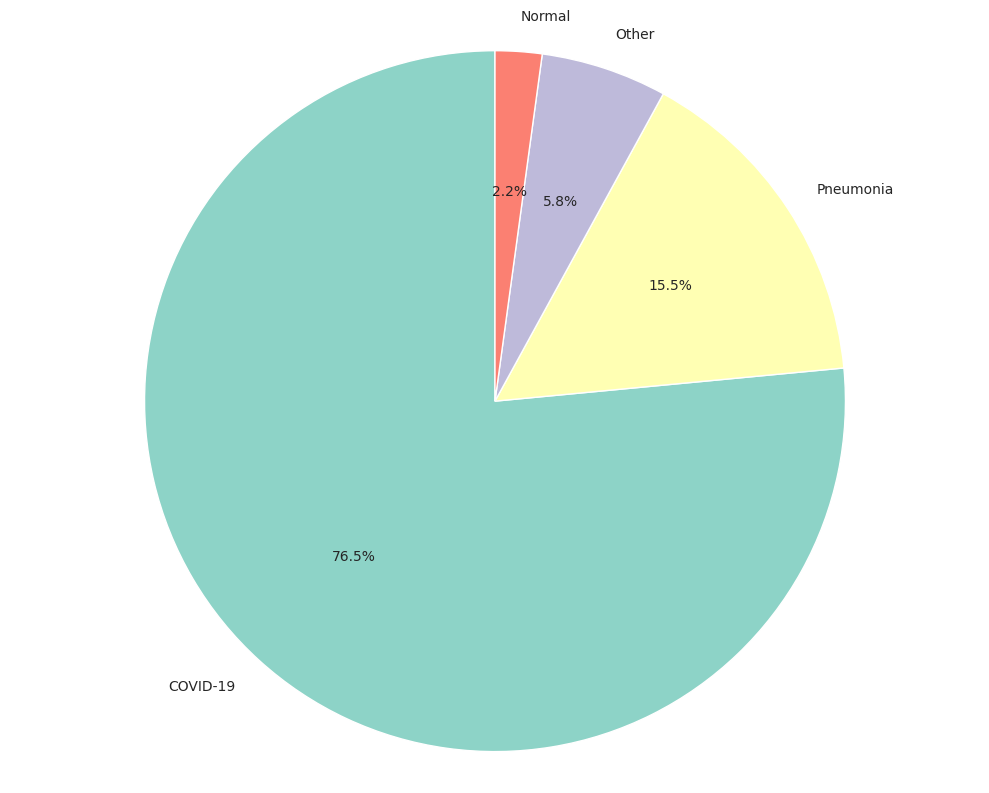

In [224]:
plt.figure(figsize=(10, 8))

diagnosis_counts = df_pandas['finding'].value_counts()
colors = plt.cm.Set3(range(len(diagnosis_counts)))

plt.pie(diagnosis_counts.values,
        labels=diagnosis_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)

# plt.title('Распределение диагнозов', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

##Столбчатая диаграмма по возрастным группам

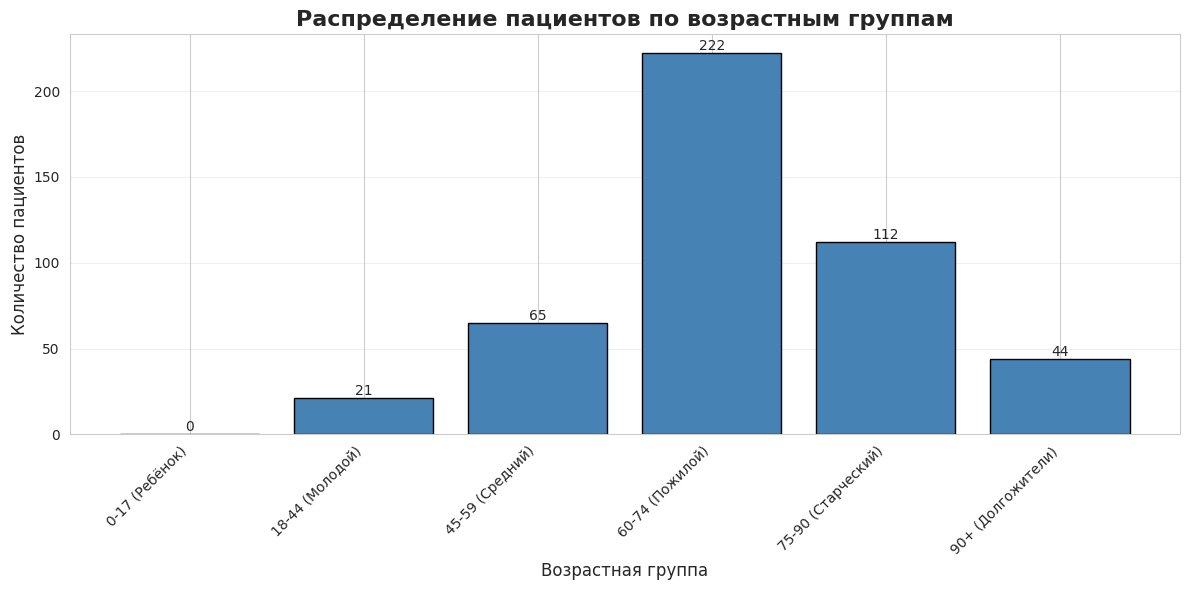

In [225]:
plt.figure(figsize=(12, 6))

age_order = ['0-17 (Ребёнок)','18-44 (Молодой)','45-59 (Средний)','60-74 (Пожилой)','75-90 (Старческий)','90+ (Долгожители)']

age_counts = df_pandas['age_category'].value_counts().reindex(age_order, fill_value=0)

bars = plt.bar(range(len(age_counts)), age_counts.values, color='steelblue', edgecolor='black')
plt.xticks(range(len(age_counts)), age_counts.index, rotation=45, ha='right')
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.title('Распределение пациентов по возрастным группам', fontsize=16, fontweight='bold')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##График временных трендов исследований

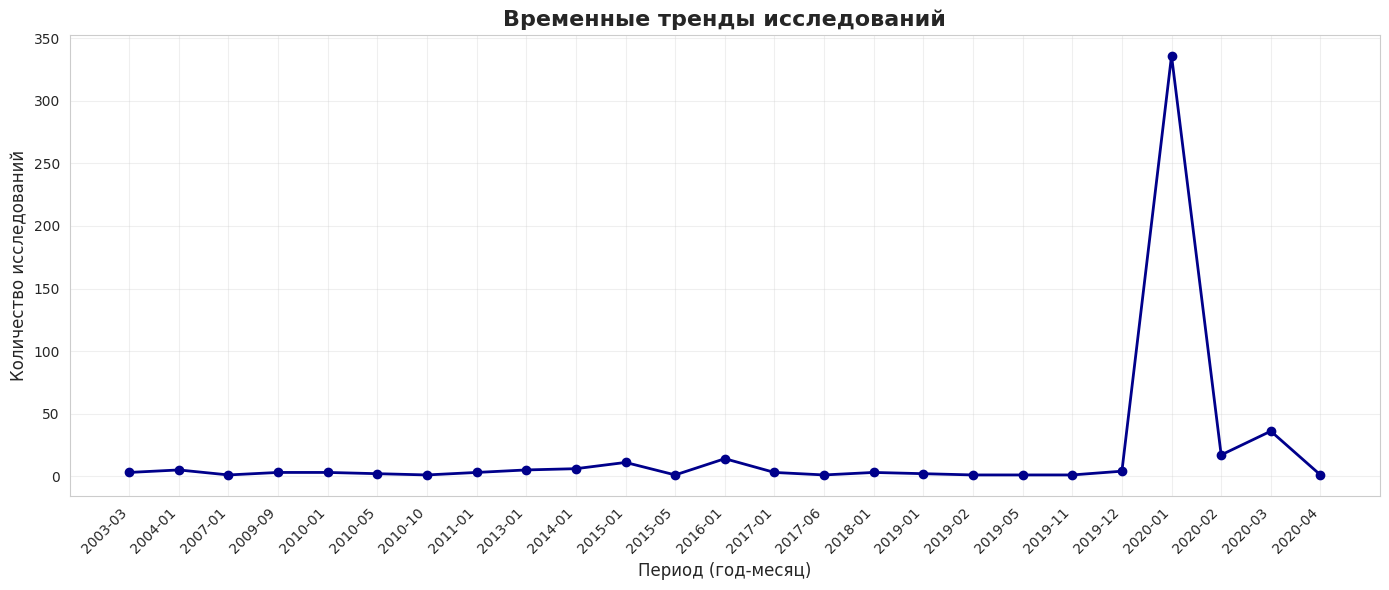

In [226]:
plt.figure(figsize=(14, 6))

# Группируем по году и месяцу
df_pandas['year'] = pd.to_datetime(df_pandas['date']).dt.year
df_pandas['month'] = pd.to_datetime(df_pandas['date']).dt.month
df_pandas['year_month'] = pd.to_datetime(df_pandas['date']).dt.to_period('M')

trend_data = df_pandas.groupby('year_month').size().reset_index(name='count')
trend_data['year_month'] = trend_data['year_month'].astype(str)

plt.plot(range(len(trend_data)), trend_data['count'],
         marker='o', linewidth=2, markersize=6, color='darkblue')

plt.xticks(range(len(trend_data)), trend_data['year_month'], rotation=45, ha='right')
plt.xlabel('Период (год-месяц)', fontsize=12)
plt.ylabel('Количество исследований', fontsize=12)
plt.title('Временные тренды исследований', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##Heatmap распределения диагнозов по проекциям снимков

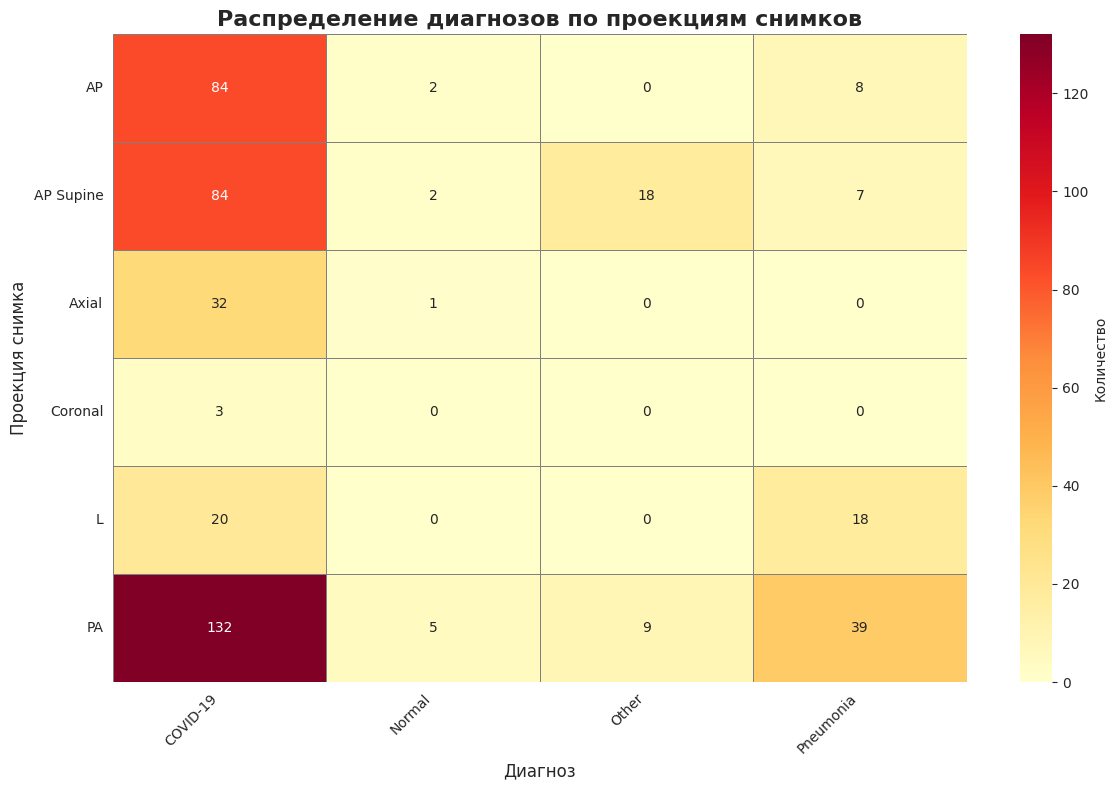

In [227]:
plt.figure(figsize=(12, 8))

# Создаем pivot таблицу
heatmap_data = df_pandas.groupby(['view', 'finding']).size().unstack(fill_value=0)

sns.heatmap(heatmap_data,
            annot=True,
            fmt='d',
            cmap='YlOrRd',
            cbar_kws={'label': 'Количество'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Распределение диагнозов по проекциям снимков', fontsize=16, fontweight='bold')
plt.xlabel('Диагноз', fontsize=12)
plt.ylabel('Проекция снимка', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()